%%latex
\tableofcontents

# Introduction

Here, we will explore the PyTorch package. To download PyTorch, visit [this link](https://pytorch.org/get-started/locally/). Tutorials can be found [here](https://pytorch.org/tutorials). We will start below with the [Introduction to Pytorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html).

It is highly recommended to, after the introduction to PyTorch tutorial, look at different [PyTorch recipes](https://pytorch.org/tutorials/recipes/recipes_index.html). These are small, bite-sized tutorials of specific features, and so at the same time propose different ways to extend the general, basic PyTorch tutorial shown below.

# Introduction to PyTorch tutorial

## Quickstart

This quickstart deals with all the features that are going to be explained in more detail in separate sections below. Here, we provide a quick overview of most common way to start using neural networks. 

### Working with data

PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

/home/thibeauwouters/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/thibeauwouters/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset. The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO. In this tutorial, we use the FashionMNIST dataset (more information about this dataset can be found [on this Kaggle page](https://www.kaggle.com/datasets/zalando-research/fashionmnist)). Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Creating models

To define a neural network in PyTorch, we create a class that inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network in the __ init __ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Optimizing model parameters

To train a model, we need a loss function and an optimizer.

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

In [7]:
def test(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [8]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.296108  [    0/60000]
loss: 2.284835  [ 6400/60000]
loss: 2.265504  [12800/60000]
loss: 2.263885  [19200/60000]
loss: 2.234288  [25600/60000]
loss: 2.216710  [32000/60000]
loss: 2.219333  [38400/60000]
loss: 2.177929  [44800/60000]
loss: 2.178759  [51200/60000]
loss: 2.159082  [57600/60000]
Test Error: 
 Accuracy: 45.4%, Avg loss: 2.142435 

Epoch 2
-------------------------------
loss: 2.151727  [    0/60000]
loss: 2.140112  [ 6400/60000]
loss: 2.075284  [12800/60000]
loss: 2.091818  [19200/60000]
loss: 2.030401  [25600/60000]
loss: 1.978954  [32000/60000]
loss: 2.004168  [38400/60000]
loss: 1.914210  [44800/60000]
loss: 1.928390  [51200/60000]
loss: 1.862888  [57600/60000]
Test Error: 
 Accuracy: 51.8%, Avg loss: 1.853600 

Epoch 3
-------------------------------
loss: 1.890799  [    0/60000]
loss: 1.857612  [ 6400/60000]
loss: 1.729984  [12800/60000]
loss: 1.771081  [19200/60000]
loss: 1.665290  [25600/60000]
loss: 1.624147  [32000/600

### Save a model

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [9]:
torch.save(model.state_dict(), "model.pth")

### Loading a model

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [10]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

### Make predictions

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## Tensors

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data (see Bridge with NumPy). Tensors are also optimized for automatic differentiation (we’ll see more about that later in the Autograd section).

### Initializing a tensor

Tensors can be initialized: 
1. directly from data
2. from a Numpy array
3. from another tensor
4. using `shape`

In [12]:
#1
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

#2
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

#3
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

#4
shape = (2,3,) # NOTE - #rows = 2, #columns = 3
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.4150, 0.7056],
        [0.8643, 0.5718]]) 

Random Tensor: 
 tensor([[0.4292, 0.9468, 0.3598],
        [0.6412, 0.6343, 0.0717]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### Attributes of a tensor

In [13]:
tensor = torch.ones((3, 4))

print(f"Tensor: \n {tensor} \n ")

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Tensor: 
 tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]) 
 
Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


### Tensor operations

Over 100 tensor operations, including arithmetic, linear algebra, matrix manipulation (transposing, indexing, slicing), sampling and more are comprehensively described [here](https://pytorch.org/docs/stable/torch.html).

Each of these operations can be run on the GPU (at typically higher speeds than on a CPU). If you’re using Colab, allocate a GPU by going to Runtime > Change runtime type > GPU.

By default, tensors are created on the CPU. We need to explicitly move tensors to the GPU using .to method (after checking for GPU availability). Keep in mind that copying large tensors across devices can be expensive in terms of time and memory!

In [14]:
# check if cuda available
torch.cuda.is_available()

False

In [15]:
## IF present: move tensor like this:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

Some examples of tensor operations are provided below. Check the details of tensor operations in the tutorial [here](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html#operations-on-tensors). Syntax very similar to numpy arrays.
* first row: `tensor[0]`
* first column: `tensor[:,0]`

A bit non-trivial is the `cat` method. **Note**: there is also the `stack` method, not to be confused.

In [16]:
print("Stack along dimension = 1")
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)
print(t1.shape)

print("Stack along dimension = 0")
t2 = torch.cat([tensor, tensor, tensor], dim = 0)
print(t2)
print(t2.shape)

Stack along dimension = 1
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
torch.Size([3, 12])
Stack along dimension = 0
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
torch.Size([9, 4])


For arithmetic computations, there are various possibilities

In [17]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# note: tensors must have compatible shapes
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)

tensor([[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]])

In [18]:
# This computes the element-wise product. z1, z2, z3 will have the same value
# note: for this, tensors must have same shapes
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

Special operations exist for **one-element tensors**.  If you have a one-element tensor, for example by aggregating all values of a tensor into one value, you can convert it to a Python numerical value using `item()`

In [19]:
agg = tensor.sum()
print(agg) # agg is a one-element TENSOR
agg_item = agg.item()
print(agg_item, type(agg_item)) # agg_item is a regular float

tensor(12.)
12.0 <class 'float'>


Also pay attention to **in-place operations**. Operations that store the result into the operand are called in-place. They are denoted by a `_` suffix. For example: `x.copy_(y)`, `x.t_()`, will change `x`. Note that some functions, like `add`, have an in-place operation equivalent - see the difference below!

In [20]:
t = torch.ones(5)
print(f'Tensor t: {t}')

print("Calling add: not stored in original tensor")
another = t.add(2)
print(f'Tensor another: {another}')
print(f'Tensor t: {t}')

print("Calling add_: stored in original tensor")
t.add_(2)
print(f'Tensor t: {t}')

Tensor t: tensor([1., 1., 1., 1., 1.])
Calling add: not stored in original tensor
Tensor another: tensor([3., 3., 3., 3., 3.])
Tensor t: tensor([1., 1., 1., 1., 1.])
Calling add_: stored in original tensor
Tensor t: tensor([3., 3., 3., 3., 3.])


### Bridge with numpy 

Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other. This is done by calling `.numpy()`. Note that, when printing, a tensor object will print `tensor()` in front of the array.

To go from tensors to numpy arrays:

In [21]:
t = torch.ones(5)
n = t.numpy()

print(f't: {t} \n') # note: "tensor()" is printed
print(f'tn {n} \n') # "tensor()" is NOT printed

print(f'Type of t: {type(t)} \n')
print(f'Type of n: {type(n)}')

t: tensor([1., 1., 1., 1., 1.]) 

tn [1. 1. 1. 1. 1.] 

Type of t: <class 'torch.Tensor'> 

Type of n: <class 'numpy.ndarray'>


Changes are reflected into each other (note: we **have** to call `add_` for this!)

In [22]:
t.add_(1) # add 1 to the tensor
print(n) # n is changed as well

[2. 2. 2. 2. 2.]


From numpy array to tensor (again: changes are reflected in both objects)

In [23]:
n = np.ones(5)
t = torch.from_numpy(n)

## Datasets & dataloaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model. You can find links in [this tutorial page](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

### Loading a dataset

Here is an example of how to load the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:
* root is the path where the train/test data is stored,
* train specifies training or test dataset,
* download=True downloads the data from the internet if it’s not available at root.
* transform and target_transform specify the feature and label transformations

In [24]:
# re-import the datasets
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Import training data. For more on arguments, see above
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Import test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [25]:
print("The training data contains %d items. The test data contains %d items." % (len(training_data), len(training_data)))

The training data contains 60000 items. The test data contains 60000 items.


### Iterating and Visualizing data

We can index Datasets manually like a list: `training_data[index]`. We use matplotlib to visualize some samples in our training data.

Note: below we generate a random integer: we call `torch.randint()` with size 1, which creates a tensor object, and then call `item()` to get it as float, not as an item. We show these steps before showing how to use this trick to visualize data.

In [26]:
random_integer_as_tensor = torch.randint(len(training_data), size=(1,))
print(random_integer_as_tensor)
random_integer_as_int = random_integer_as_tensor.item()
print(random_integer_as_int)

tensor([50376])
50376


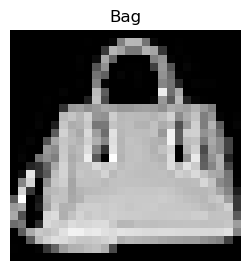

In [27]:
labels_map = {0: "T-Shirt", 1: "Trouser", 2: "Pullover",  3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

figure = plt.figure(figsize=(3, 3))
cols, rows = 1, 1 # change this to plot more

for i in range(1, cols * rows + 1):
    
    # Generate random number, get data item from it:
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    
    # Show it:
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

    plt.show()

### Creating custom datasets

A custom Dataset class must implement three functions: __ init __, __ len __, and __ getitem __. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In the next sections, we’ll break down what’s happening in each of these functions.

In [28]:
import os
import pandas as pd # note, we use pandas!
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        
        # Note: img labels is a pandas dataset
        self.img_labels = pd.read_csv(annotations_file)
        
        # Save other quantities
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        
        return len(self.img_labels)

    def __getitem__(self, idx):
        '''The __getitem__ function loads and returns a sample from the dataset at the given index idx. 
        Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, 
        retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), 
        and returns the tensor image and corresponding label in a tuple'''
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

### Preparing data for training with DataLoaders

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API. Below, the batch size is 64, and we shuffle it (shuffle = True).

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader  = DataLoader(test_data, batch_size = 64, shuffle = True)

### Iterate through the DataLoader

We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).

Note: `iter` creates an iterable (more info: [here](https://www.geeksforgeeks.org/python-iter-method/)). 

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


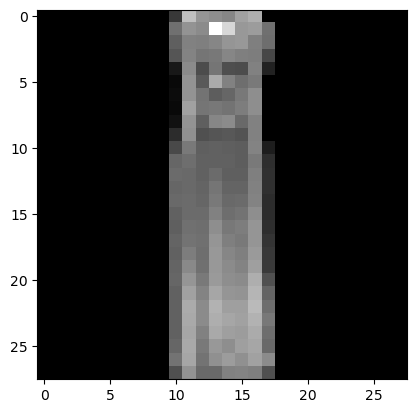

Label: 3


In [33]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

# Plot it
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Transforms

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters:
1. `transform`: to modify the features, and 
2. `target_transform` to modify the labels

These accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box. For the dataset, we do the following. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda (which is like [Python's built in lambda function](https://www.w3schools.com/python/python_lambda.asp)). 

1. __Modify features:__ The FashionMNIST features are in PIL Image (PIL stands for _Python Imaging Library_) format (they are the 28 x 28 pixels of each image), and the labels are integers (`0` stands for "T-Shirt", `1` stands for "Trouser", etc). Below, we call ToTensor() to deal with these features. ToTensor() converts a PIL image or NumPy ndarray into a FloatTensor and scales the image's pixel intensity values in the range [0., 1.]

2. __Modify labels:__ This is done via Lambda transforms. These apply any user-defined lambda function. Here, we define a function to turn the integer (of the labels: 0 for T-shirt etc) into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y. So instead of using the integers as labels, we create 10D vectors of zeroes, and put a 1 in the index position of the initial label. The benefit of one-hot encoding tensors can be read in [this StackExchange post](https://datascience.stackexchange.com/questions/30215/what-is-one-hot-encoding-in-tensorflow)

These operations are done in the final two lines of the following code block.

In [38]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value = 1))
)

## Building neural networks

Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In the following sections, we’ll build a neural network to classify images in the FashionMNIST dataset.

### Get the device for training

We want to be able to train our model on a hardware accelerator like the GPU, if it is available. Let’s check to see if torch.cuda is available, else we continue to use the CPU.

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Define the class

We define our neural network by subclassing nn.Module, and initialize the neural network layers in __ init __. Every nn.Module subclass implements the operations on input data in the forward method.

In [ ]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        
        super(NeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of NeuralNetwork, and move it to the device, and print its structure.



In [40]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Note: the output is interpreted (by me personally) as follows. Lines (0), (2) and (4) contain information on the neural network architecture. In terms of the typical drawings of neural networks using nodes, the features denote the number of nodes. Indeed, the input layer has 784 input nodes. This comes from 28 x 28 = 724, so these nodes represent the pixels of the dataset. The output is towards a hidden layer. All hidden layers have 512 features. I'm not too sure where this comes from. I thought the number of "hidden features" may be related to the fact that we represent these as 10D vectors, but that may give $2^{10} = 1024$ features, which is twice as much as here. Some factor $2$ is missing - maybe due to normalization of the vectors, such that only 9 of them are degrees of freedom? Not sure... The final output layer has 10 output features, and these are the conventional labels as before (0 = T-Shirt and so on). 

To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. Do not call model.forward() directly!

Calling the model on the input returns a 10-dimensional tensor with raw predicted values for each class. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

Below, the input X is a random greyscale field: 28 x 28 as before. NOTE: shape is [1, 28, 28]: the first number is related to the number of images in each of the "batches" (in this case, only a single image). This first number is called the **minibatch dimension**.

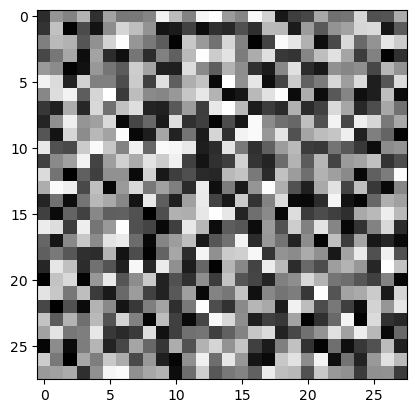

Predicted class: tensor([3])


In [56]:
X = torch.rand(1, 28, 28, device = device)

# Plot X, like above
img = X[0].squeeze()

# Plot it
plt.imshow(img, cmap="gray")
plt.show()

# Call neural network and make prediction
logits = model(X)
pred_probab = nn.Softmax(dim = 1)(logits)
y_pred = pred_probab.argmax(1)

print(f"Predicted class: {y_pred}")

### Model layers

Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network.

In [67]:
input_image = torch.rand(3,28,28) # 3, for 3 figures

#### nn.Flatten

nn.Flatten: We initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

In [68]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


Note that, above, the first line is used to get the Flatten function, which is part of the neural network class, as a separate function outside of the neural networks. We can skip this step, as we do in part (3).

#### nn.Linear

The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

In [69]:
layer1 = nn.Linear(in_features = 28*28, out_features = 20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


__Question:__ Why 20 output features?

#### nn.ReLU

nn.ReLU: Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena.

In this model, we use nn.ReLU between our linear layers, but there’s other activations to introduce non-linearity in your model

In [70]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.2754,  0.1584,  0.6333, -0.4623,  0.4798, -0.3715, -0.1056,  0.5117,
         -0.1805,  0.0628,  0.4670,  0.1774, -0.1796,  0.4503,  0.4220, -0.1664,
          0.5512, -0.1496, -0.0010, -0.1214],
        [ 0.5376,  0.2432,  0.3664, -0.2721,  0.3685, -0.5282, -0.0057,  0.3079,
          0.0418,  0.0192,  0.0846, -0.0133, -0.0085,  0.9007,  0.2108,  0.0835,
          0.7500,  0.0809,  0.1142, -0.1203],
        [ 0.2543,  0.1581,  0.3466, -0.3639,  0.1763, -0.0905,  0.5186,  0.0815,
         -0.1698, -0.1660,  0.3123,  0.0789, -0.1554,  0.5723, -0.1543,  0.0654,
          0.4454,  0.1179,  0.2233, -0.5287]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.2754, 0.1584, 0.6333, 0.0000, 0.4798, 0.0000, 0.0000, 0.5117, 0.0000,
         0.0628, 0.4670, 0.1774, 0.0000, 0.4503, 0.4220, 0.0000, 0.5512, 0.0000,
         0.0000, 0.0000],
        [0.5376, 0.2432, 0.3664, 0.0000, 0.3685, 0.0000, 0.0000, 0.3079, 0.0418,
         0.0192, 0.0846, 0.0000, 0.0000, 0.9007, 0.21

#### nn.Sequential

We organize all of the above steps in one network. This is done via nn.Sequential(), which is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network like seq_modules.

In [74]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)

input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

#### nn.Softmax

The last linear layer of the neural network returns logits (raw values in [-infty, infty]) which are passed to the nn.Softmax module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1. The details about the Softmax function can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)

In [75]:
softmax = nn.Softmax(dim = 1)
pred_probab = softmax(logits)
print(pred_probab)

tensor([[0.0819, 0.1054, 0.1366, 0.1138, 0.0962, 0.1157, 0.0932, 0.0663, 0.0893,
         0.1016],
        [0.0967, 0.1058, 0.1411, 0.1100, 0.0884, 0.1163, 0.0927, 0.0659, 0.0792,
         0.1038],
        [0.0901, 0.1062, 0.1300, 0.1032, 0.0998, 0.1313, 0.0852, 0.0690, 0.0854,
         0.0999]], grad_fn=<SoftmaxBackward0>)


### Model parameters

Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training. Subclassing nn.Module automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s parameters() or named_parameters() methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.

In [78]:
print(f"Model structure: {model}\n\n")

layer_counter = 0
for name, param in model.named_parameters():
    print("Layer %d" % layer_counter)
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
    layer_counter += 1

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer 0
Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0128,  0.0328, -0.0283,  ..., -0.0321,  0.0332,  0.0034],
        [ 0.0293,  0.0036, -0.0224,  ..., -0.0355, -0.0257,  0.0069]],
       grad_fn=<SliceBackward0>) 

Layer 1
Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0321,  0.0207], grad_fn=<SliceBackward0>) 

Layer 2
Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0335,  0.0104, -0.0407,  ...,  0.0073, -0.0072, -0.0430],
        [ 0.0278,  0.0236, -0.0267,  ...,  0.0174, -0.0145, -0.0006]],
       grad_fn=<SliceBackward0>) 

Layer 3
La

Some observations:
* Even-numbered layers in the above neural network correspond to hidden layers, which receive a certain input (tensor of a certain dimension) and have an output (another tensor of a certain, possible different shape). As such, their shape is characterized by two numbers, as can be seen from torch.size. Their shape is [size_out, size_in].
* odd-numbered layers in the above neural network correspond to the ReLU stacks. They have a single dimension, equal to the output dimension of the previous layer. 

## Automatic differentiation with torch.autograd

When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input `x`, parameters `w` and `b`, and some loss function. Suppose we want to make a neural network that adjusts its parameters such that its predicted outcome is a vector containing zeroes. The expected outcome is frequently called `y`. We make predicitions from this simple model by the operation
$$
z = wx + b
$$
and try to optimize the parameters and get `z` as close as possible to `y`.

The neural network can be defined in PyTorch in the following manner:

In [87]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output

# Build the neural network
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)

print("Weights are: ", w)
print("Bias is: ", b)

# Make a prediction
z = torch.matmul(x, w) + b
print("Prediction is: ", z)
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

Weights are:  tensor([[ 1.1601, -1.1272,  0.0907],
        [-0.6276, -0.3242,  2.3798],
        [ 0.1758,  0.4598, -0.4319],
        [ 0.0734, -0.0180,  0.9507],
        [ 0.6712, -0.0732,  0.0809]], requires_grad=True)
Bias is:  tensor([ 1.7938,  0.5476, -0.3545], requires_grad=True)
Prediction is:  tensor([ 3.2468, -0.5353,  2.7157], grad_fn=<AddBackward0>)


In [88]:
loss

tensor(2.1752, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the requires_grad property of those tensors. You can set the value of requires_grad when creating a tensor, or later by using x.requires_grad_(True) method. 

A function that we apply to tensors to construct computational graph is in fact an object of class Function. This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in grad_fn property of a tensor. You can find more information of Function in the documentation.

In [89]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f68d6bff2e0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f68d6bff100>


To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely  under some fixed values of x and y. To compute those derivatives, we call loss.backward(), and then retrieve the values from w.grad and b.grad:

### Computing gradients

In [90]:
loss.backward()
print(w.grad)
print(b.grad)

tensor(2.1752, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor([[0.3209, 0.1231, 0.3126],
        [0.3209, 0.1231, 0.3126],
        [0.3209, 0.1231, 0.3126],
        [0.3209, 0.1231, 0.3126],
        [0.3209, 0.1231, 0.3126]])
tensor([0.3209, 0.1231, 0.3126])


A few comments are in order:
* We can only obtain the grad properties for the leaf nodes of the computational graph, which have requires_grad property set to True. For all other nodes in our graph, gradients will not be available.
* We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.

### Disable gradient tracking

By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with torch.no_grad() block:

In [92]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
    print(z.requires_grad)

True
False


In [93]:
z = torch.matmul(x, w)+b
z_det = z.detach() # note that we create a copy of z and store it without the gradient requirement
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:
* To mark some parameters in your neural network as frozen parameters. This is a very common scenario for finetuning a pretrained network
* To speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

### More on computational graphs

Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:
* run the requested operation to compute a resulting tensor
* maintain the operation’s gradient function in the DAG.

The backward pass kicks off when .backward() is called on the DAG root. autograd then:
* computes the gradients from each .grad_fn,
* accumulates them in the respective tensor’s .grad attribute
* using the chain rule, propagates all the way to the leaf tensors.

An important thing to note is that the graph is recreated from scratch; after each .backward() call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed.

__Optional:__ Further reading about tensor gradients can be read [here](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#optional-reading-tensor-gradients-and-jacobian-products).

## Optimizing model parameters

Now that we have a model and data it’s time to train, validate and test our model by optimizing its parameters on our data. Training a model is an iterative process; in each iteration (called an epoch) the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters (as we saw in the previous section), and optimizes these parameters using gradient descent. For a more detailed walkthrough of this process, [check out this video on backpropagation from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

Below, we copy-paste the code from previous sections.

In [94]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

### Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates (read more about hyperparameter tuning)

We define the following hyperparameters for training:
1. Number of Epochs - the number times to iterate over the dataset
2. Batch Size - the number of data samples propagated through the network before the parameters are updated
3. Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [95]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### Optimization loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
1. The Train Loop - iterate over the training dataset and try to converge to optimal parameters.
2. The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

Let's briefly familiarize ourselves with some of the concepts used in the training loop.

#### Loss function

When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

We pass our model’s output logits to nn.CrossEntropyLoss, which will normalize the logits and compute the prediction error.

In [96]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

#### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed. In this example we use Stochastic Gradient Descent (SGD). Stochastic Gradient Descent can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). 

All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

In [97]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

Inside the training loop, optimization happens in three steps:
1. Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
2. Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.
3. Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

#### Full implementation

In [110]:
def train_loop(dataloader, model, loss_fn, optimizer):
#     '''This is the training loop. It requires
#         - the dataloader
#         - the model
#         - the loss function
#         - the optimizer object'''
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation happens here:
        optimizer.zero_grad() # reset the gradietnts
        loss.backward() # backpropagate the error
        optimizer.step() # update the params

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
#         '''This is the training loop. It requires
#         - the dataloader
#         - the model
#         - the loss function '''
        
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0

    # Below, we call "no grad", as we are NOT going to update params here
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to train_loop and test_loop. Feel free to increase the number of epochs to track the model’s improving performance.

In [111]:
# Initialize loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train and update:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.310596  [    0/60000]
loss: 2.291528  [ 6400/60000]
loss: 2.270650  [12800/60000]
loss: 2.262007  [19200/60000]
loss: 2.258055  [25600/60000]
loss: 2.226152  [32000/60000]
loss: 2.232859  [38400/60000]
loss: 2.205753  [44800/60000]
loss: 2.198505  [51200/60000]
loss: 2.165927  [57600/60000]
Test Error: 
 Accuracy: 44.5%, Avg loss: 2.159703 

Epoch 2
-------------------------------
loss: 2.176373  [    0/60000]
loss: 2.164047  [ 6400/60000]
loss: 2.105942  [12800/60000]
loss: 2.115578  [19200/60000]
loss: 2.070878  [25600/60000]
loss: 2.015792  [32000/60000]
loss: 2.035710  [38400/60000]
loss: 1.966682  [44800/60000]
loss: 1.965048  [51200/60000]
loss: 1.892540  [57600/60000]
Test Error: 
 Accuracy: 52.4%, Avg loss: 1.887255 

Epoch 3
-------------------------------
loss: 1.928944  [    0/60000]
loss: 1.899168  [ 6400/60000]
loss: 1.776495  [12800/60000]
loss: 1.811657  [19200/60000]
loss: 1.704570  [25600/60000]
loss: 1.657769  [32000/600

## Saving and loading a model

In [113]:
import torchvision.models as models

PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:

In [114]:
model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

/home/thibeauwouters/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/thibeauwouters/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/thibeauwouters/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In [115]:
model = models.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_weights.pth'))

model.eval() # THIS STEP IS IMPORTANT!!!

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

### Saving and Loading Models with Shapes

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass model (and not model.state_dict()) to the saving function. Models can be saved as follows:

In [116]:
torch.save(model, 'model.pth')

And models can be loaded again as follows:

In [117]:
model = torch.load('model.pth')

This approach uses Python pickle module when serializing the model, thus it relies on the actual class definition to be available when loading the model.